In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Flatten, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

# Data Input and Model Creation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Concatenate positive and negative samples
trainFull = pd.read_csv("drive/MyDrive/PreprocessedData/trainFull.csv")
testFull = pd.read_csv("drive/MyDrive/PreprocessedData/testFull.csv")
    
#Randomize samples
trainFull = trainFull.sample(len(trainFull))
testFull = testFull.sample(len(testFull))

#Randomize samples
trainFull = trainFull.sample(len(trainFull))
testFull = testFull.sample(len(testFull))


In [ ]:
#Reduce features and extract labels
trainX = trainFull.iloc[:,:-2]
trainY = trainFull.iloc[:,-1]
testX = testFull.iloc[:,:-2]
testY = testFull.iloc[:,-1]
#Standard scale training data
trainScaler = StandardScaler()
trainScaler.fit(trainX)
trainX = trainScaler.transform(trainX)

#Export standard scale
#dump(trainScaler, 'standardScaler.bin', compress=True)

#Standard scale testing data
testScaler = StandardScaler()
testScaler.fit(testX)
testX = testScaler.transform(testX)

#Reshape data to 3D for CNN
trainX = trainX[..., None]
trainY = trainY[..., None]
testX = testX[..., None]
testY = testY[..., None]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [ ]:
"""
This method contains the architecture for the CNN used.
It uses tensorflow sequential as the basis to crease the model.

@param numConvFilters: number of convolutional filters in the 2nd hidden layer. We recommend >32 to upscale.
@param dropout: fraction of nodes dropped out of the Max Pooling layer.
@param numDenseNodes: number of dense nodes in the feed forward layer.

Recommended:
numConvFilters = 242
dropout = .215
numDenseNodes = 190

"""
def newModel(numConvFilters = 242, dropout = .215, numDenseNodes = 190):
    #Create new sequential model
    model = Sequential()

    #Add 1D Convolutional layers
    model.add((Conv1D(filters=32, kernel_size=3, activation='relu')))
    model.add((Conv1D(filters=numConvFilters, kernel_size=3, activation='relu')))
    #Add Max Pooling layer
    model.add((MaxPooling1D(pool_size=2)))
    #Apply dropout
    model.add(Dropout(dropout))
    #Flatten model
    model.add(Flatten())
    #Add fully connected dense layer
    model.add(Dense(numDenseNodes, activation='sigmoid'))
    #Add output node
    model.add(Dense(1, activation='sigmoid'))
    
    #Define optimizer
    adam = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #Compile model
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'),                                                                                         tf.keras.metrics.PrecisionAtRecall(0.8)])
    return model

In [ ]:
model = newModel()
model.fit(trainX, trainY, epochs = 30, batch_size=20, verbose = 1)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


758/758 [==============================] - 22s 28ms/step - loss: 0.5701 - auc_2: 0.7747 - precision_at_recall_2: 0.6539
Epoch 2/30
758/758 [==============================] - 22s 29ms/step - loss: 0.5215 - auc_2: 0.8231 - precision_at_recall_2: 0.6977
Epoch 3/30
758/758 [==============================] - 22s 29ms/step - loss: 0.5025 - auc_2: 0.8372 - precision_at_recall_2: 0.7155
Epoch 4/30
758/758 [==============================] - 21s 28ms/step - loss: 0.4864 - auc_2: 0.8489 - precision_at_recall_2: 0.7260
Epoch 5/30
758/758 [==============================] - 22s 28ms/step - loss: 0.4703 - auc_2: 0.8597 - precision_at_recall_2: 0.7459
Epoch 6/30
758/758 [==============================] - 22s 29ms/step - loss: 0.4573 - auc_2: 0.8693 - precision_at_recall_2: 0.7597
Epoch 7/30
758/758 [==============================] - 22s 28ms/step - loss: 0.4454 - auc_2: 0.8760 - precision_at_recall_2: 0.7713
Epoch 8/30
758/758 [==============================] - 22s 28ms/step - loss: 0.4329 - auc_2: 0.

# Validation and Analysis 

In [ ]:
#create confusion Matrix
def confusionMatrix(model, testX, testY):
    pred = model.predict(testX)
    predy = []
    for i in range(0,len(pred)):
        if pred[i] >= .5:
            predy.append(1)
        else:
            predy.append(0)
        
    print(confusion_matrix(testY,predy))
    
#Calculates our model metrics
def modelMetrics(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    rec80 = np.max(recall[precision >= .8])
    print("Recall at 80% Precision: " +str(rec80))
    aucPR = auc(recall, precision)
    print("PR-AUC: " + str(aucPR))
    
    return rec80, aucPR, 

#plots a PR curve
def PRplot(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    plt.plot(recall, precision)
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

Recall at 80% Precision: 0.9050131926121372
PR-AUC: 0.9229010413489216
[[1579  316]
 [ 269 1626]]


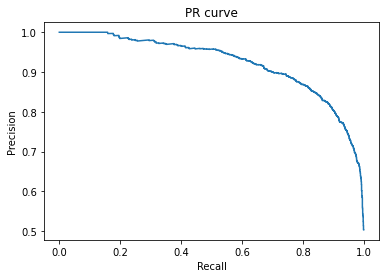

In [ ]:
modelMetrics(testX, testY, model)
confusionMatrix(model, testX, testY)
PRplot(testX, testY, model)

OTHER MODELS

RF STARTS

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split,KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import numpy as np
# from fastcore.all import *
from collections import defaultdict
# import optuna
from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr
from matplotlib import pyplot as plt

In [ ]:
trainX_Org = trainFull.iloc[:,:-2]
trainY_Org = trainFull.iloc[:,-1]

testX_Org = testFull.iloc[:,:-2]
testY_Org = testFull.iloc[:,-1]

#Standard scale training data
trainScaler = StandardScaler()
trainScaler.fit(trainX_Org)
trainX_Org = trainScaler.transform(trainX_Org)

#Standard scale testing data
testScaler = StandardScaler()
testScaler.fit(testX_Org)
testX_Org = testScaler.transform(testX_Org)

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_features=0.5,
    min_samples_leaf=4,
    oob_score=True,
    n_jobs=-1,
)
rf_clf.fit(trainX_Org ,trainY_Org)


RandomForestClassifier(max_features=0.5, min_samples_leaf=4, n_jobs=-1,
                       oob_score=True)

Recall at 80% Precision: 0.7757255936675461
PR-AUC: 0.8580159054591401
[[1590  305]
 [ 425 1470]]


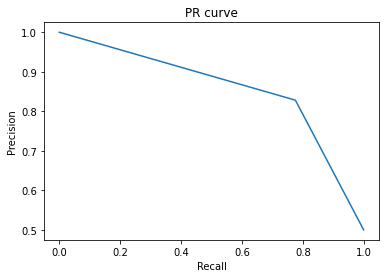

In [ ]:
modelMetrics(testX_Org, testY_Org, rf_clf)
confusionMatrix(rf_clf, testX_Org, testY_Org)
PRplot(testX_Org, testY_Org, rf_clf)

RF ENDS

SVM STARTS

In [ ]:
from sklearn import svm
svm_clf = svm.SVC()
svm_clf.fit(trainX_Org, trainY_Org)


SVC()

Recall at 80% Precision: 0.0
PR-AUC: 0.8231980124500692
[[1495  400]
 [ 497 1398]]


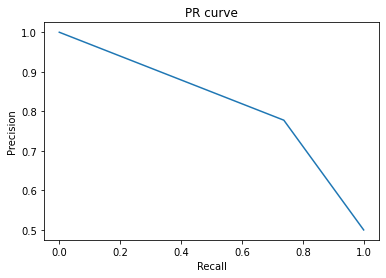

In [ ]:
modelMetrics(testX_Org, testY_Org, svm_clf)
confusionMatrix(svm_clf, testX_Org, testY_Org)
PRplot(testX_Org, testY_Org, svm_clf)

NAIVE BAYSE

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(trainX_Org, trainY_Org)

GaussianNB()

Recall at 80% Precision: 0.0
PR-AUC: 0.7202914233197948
[[1531  364]
 [1013  882]]


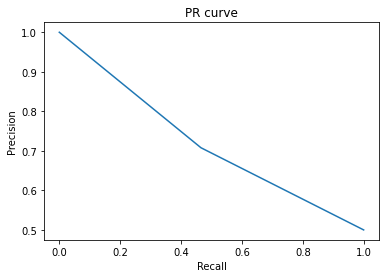

In [ ]:
modelMetrics(testX_Org, testY_Org, nb_clf)
confusionMatrix(nb_clf, testX_Org, testY_Org)
PRplot(testX_Org, testY_Org, nb_clf)

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(solver = 'saga')
lr_clf.fit(trainX_Org, trainY_Org)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(solver='saga')

Recall at 80% Precision: 0.0
PR-AUC: 0.7886202684258745
[[1398  497]
 [ 569 1326]]


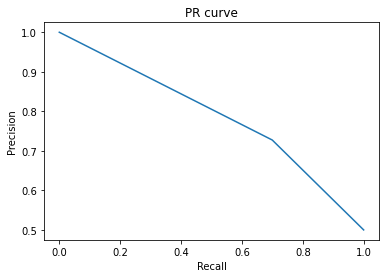

In [ ]:
modelMetrics(testX_Org, testY_Org, lr_clf)
confusionMatrix(lr_clf, testX_Org, testY_Org)
PRplot(testX_Org, testY_Org, lr_clf)

In [ ]:
trainX_Org

array([[-0.46383342, -0.48047996, -1.00154686, ..., -0.06292102,
        -0.06950486, -0.17422432],
       [-0.24016716, -0.4350187 , -1.75047717, ..., -0.06292102,
        -0.06950486, -0.17422432],
       [-0.35200029, -0.30161599,  0.40764041, ..., -0.06292102,
        -0.06950486, -0.17422432],
       ...,
       [-0.27744487, -0.17044908,  0.78561484, ..., -0.06292102,
        -0.06950486, -0.17422432],
       [ 0.02077681, -0.0497159 , -0.44234556, ..., -0.06292102,
        -0.06950486, -0.17422432],
       [ 0.24444307,  0.38104816,  0.29260472, ..., -0.06292102,
        -0.06950486, -0.17422432]])

In [ ]:
trainX

array([[[-0.46383342],
        [-0.48047996],
        [-1.00154686],
        ...,
        [-0.06292102],
        [-0.06950486],
        [-0.17422432]],

       [[-0.24016716],
        [-0.4350187 ],
        [-1.75047717],
        ...,
        [-0.06292102],
        [-0.06950486],
        [-0.17422432]],

       [[-0.35200029],
        [-0.30161599],
        [ 0.40764041],
        ...,
        [-0.06292102],
        [-0.06950486],
        [-0.17422432]],

       ...,

       [[-0.27744487],
        [-0.17044908],
        [ 0.78561484],
        ...,
        [-0.06292102],
        [-0.06950486],
        [-0.17422432]],

       [[ 0.02077681],
        [-0.0497159 ],
        [-0.44234556],
        ...,
        [-0.06292102],
        [-0.06950486],
        [-0.17422432]],

       [[ 0.24444307],
        [ 0.38104816],
        [ 0.29260472],
        ...,
        [-0.06292102],
        [-0.06950486],
        [-0.17422432]]])

Analysis

In [ ]:
#Calculates our model metrics
def modelMetrics(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    rec80 = np.max(recall[precision >= .8])
    print("Recall at 80% Precision: " +str(rec80))
    aucPR = auc(recall, precision)
    print("PR-AUC: " + str(aucPR))
    
    return rec80, aucPR, 

In [ ]:
modelMetrics(testX, testY, rf_clf)

In [ ]:
modelMetrics(testX, testY, svm_clf)